In [36]:
parPercents=[83.8202, 84.1504, 84.4806, 84.8108, 85.1410, 85.4712, 85.8014, 86.1316, 86.4816, 86.7920, 87.1222, 87.4524, 87.7826, 88.1128, 88.4430]
superfluousPercents=list(range(2, 31, 2))
egPercents=[100-par for par in parPercents]
egPercents

[16.1798,
 15.849599999999995,
 15.519400000000005,
 15.1892,
 14.858999999999995,
 14.528800000000004,
 14.198599999999999,
 13.868399999999994,
 13.5184,
 13.207999999999998,
 12.877799999999993,
 12.547600000000003,
 12.217399999999998,
 11.887200000000007,
 11.557000000000002]

In [37]:
(5.5/807.51)/((5.5/807.51)+(31)/914)

0.16723325929205807

In [38]:
nonsuperfluousPar=[par-sup for par, sup in zip(parPercents, superfluousPercents)]
nonsuperfluousEGPer=[egPer/(egPer+nonSupPar) for egPer, nonSupPar in zip(egPercents, nonsuperfluousPar)]

In [39]:
nonsuperfluousEGPer

[0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16485853658536584,
 0.16509999999999997,
 0.1650999999999999,
 0.16510000000000002,
 0.16509999999999997,
 0.1651000000000001,
 0.16510000000000002]

(15, 15)

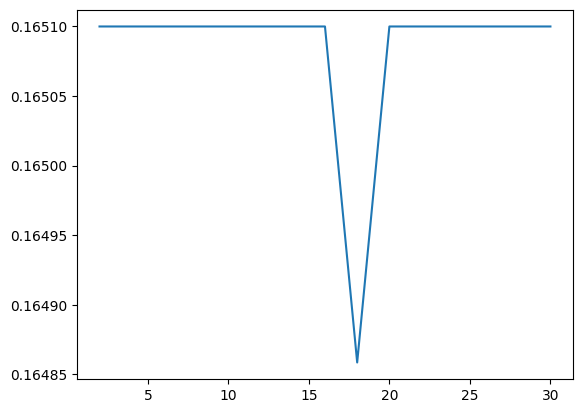

In [41]:
import matplotlib.pyplot as plt
plt.plot(superfluousPercents, nonsuperfluousEGPer)
len(superfluousPercents), len(nonsuperfluousEGPer)

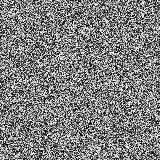

In [30]:
absorptionRate=.1651
import random
import torch
import torchvision as tv
from collections import deque

grid=torch.rand((160, 160))

tensorToImageTransform=tv.transforms.ToPILImage()

def corePhase(grid, prob=0.05):
    return (grid>prob).float()

tensorToImageTransform(grid)

def generateSample(grid, coreProb, growthProb, superfluousPar):
    # grid=corePhase(grid, coreProb)
    bfs=deque()
    rows, cols = 160, 160
    for row in range(rows):
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=0
                bfs.append([row, col])

    totVol=rows*cols
    egVol=0

    iters=0
    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]

    while (totVol-egVol)/totVol>superfluousPar:
        [currX, currY]=bfs.popleft()
        flag=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if random.random()<growthProb and grid[nx][ny]==1:
                egVol+=1
                bfs.append([nx, ny])
                grid[nx][ny]=0
            if grid[nx][ny]==1:
                flag=True
        if flag:
            bfs.append([currX, currY])
        # iters+=1
        # if iters%1000==0:
        #     print((totVol-egVol)/totVol)
        #     display(tensorToImageTransform(grid))
    
    return grid

# grid=generateSample(grid, 0.002, 0.25, 0.2)
display(tensorToImageTransform(grid))

In [33]:
import cProfile
# grid=torch.rand((160, 160))
grid=[[1]*160 for i in range(160)]
cProfile.run('grid=generateSample(grid, 0.002, 0.25, 0.2)', sort='tottime')


         513642 function calls (513640 primitive calls) in 0.201 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.113    0.113    0.162    0.162 472917973.py:16(generateSample)
   414299    0.050    0.000    0.050    0.000 {method 'random' of '_random.Random' objects}
        6    0.021    0.004    0.030    0.005 socket.py:626(send)
    50288    0.008    0.000    0.008    0.000 {method 'append' of 'collections.deque' objects}
    48774    0.008    0.000    0.008    0.000 {method 'popleft' of 'collections.deque' objects}
        8    0.000    0.000    0.000    0.000 ipkernel.py:775(_clean_thread_parent_frames)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.162    0.162 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 threading.py:1533(enumerate)
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '

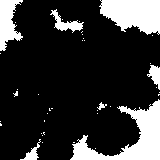

In [42]:
grid_tensor=torch.tensor(grid, dtype=torch.float32)
display(tensorToImageTransform(grid_tensor))

In [48]:
#eg true density
egDensity=2200
parDensity=914
egPerSaturatedEG=sum(nonsuperfluousEGPer)/len(nonsuperfluousEGPer)

totVol=160*160
saturatedEgVol=len(torch.nonzero(grid_tensor==0))
superfluousParVol=totVol-saturatedEgVol
parVol=superfluousParVol+(1-egPerSaturatedEG)*saturatedEgVol
egVol=egPerSaturatedEG*saturatedEgVol
egWeight=egVol*egDensity
parWeight=parVol*parDensity
egWeight/(egWeight+parWeight)

0.2686356249094599

In [50]:
superfluousParVol/(superfluousParVol+saturatedEgVol)
13.2
egVol/(saturatedEgVol+superfluousParVol)

0.13239600003810978

[deque([[37, 26]]), deque([[158, 6]]), deque([[52, 11]]), deque([[98, 113]]), deque([[56, 85]]), deque([[146, 129]]), deque([[64, 14]]), deque([[121, 101]]), deque([[6, 59]]), deque([[73, 30]]), deque([[95, 82]]), deque([[11, 33]]), deque([[138, 127]]), deque([[15, 55]]), deque([[129, 145]]), deque([[139, 4]]), deque([[47, 147]]), deque([[136, 49]]), deque([[149, 3]]), deque([[44, 49]]), deque([[106, 13]]), deque([[118, 23]]), deque([[87, 59]]), deque([[89, 56]]), deque([[153, 135]]), deque([[94, 96]]), deque([[72, 101]]), deque([[14, 158]]), deque([[59, 16]]), deque([[97, 76]])]
[[0.011842105263157895, 0.04026315789473684, 0.05802631578947368, 0.12302631578947368], [0.09025641025641026, 0.005384615384615384, 0.03487179487179488, 0.005], [0.025500000000000002, 0.046799999999999994, 0.18400000000000002, 0.0132], [0.07578947368421052, 0.014210526315789474, 0.02736842105263158, 0.03631578947368421], [0.01904761904761905, 0.075, 0.075, 0.17142857142857143], [0.015, 0.0012903225806451613, 0

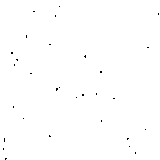

0.9961328125


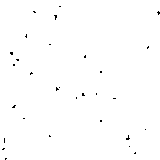

0.992734375


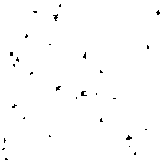

0.98828125


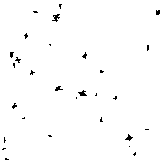

0.9827734375


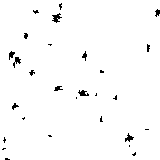

0.97609375


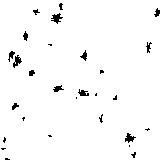

0.9680859375


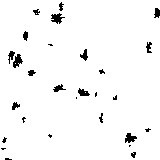

0.957890625


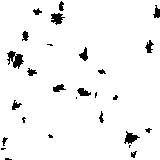

0.9483984375


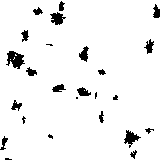

0.9365234375


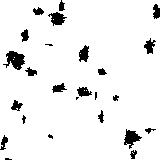

0.92296875


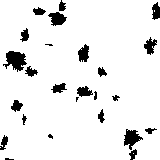

0.9080859375


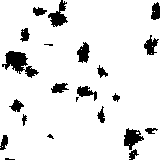

0.8925


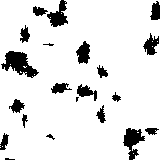

0.875234375


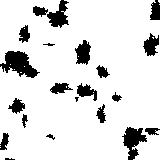

0.85734375


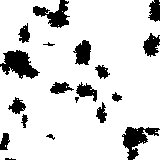

0.8387109375


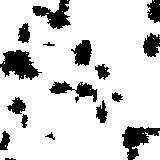

0.8205859375


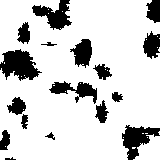

0.802265625


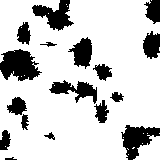

0.78234375


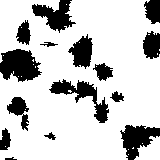

0.7615625


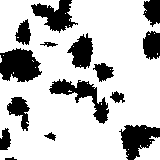

0.73984375


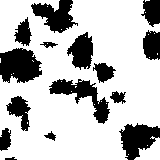

0.718828125


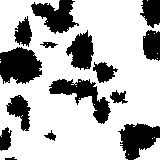

0.6971484375


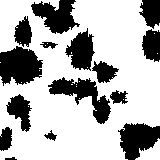

0.674609375


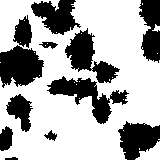

0.6528125


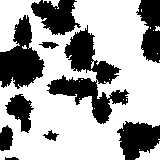

0.630546875


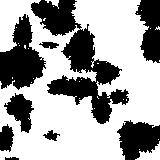

0.6065625


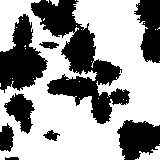

0.58109375


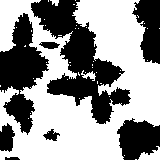

0.55625


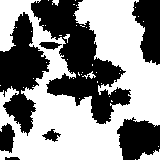

0.533046875


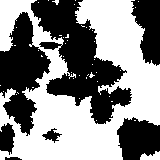

0.5122265625


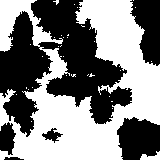

0.48890625


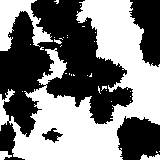

0.4664453125


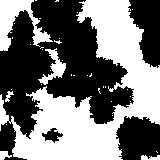

0.44546875


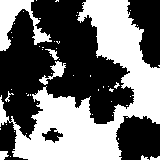

0.4235546875


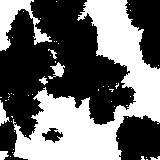

0.4042578125


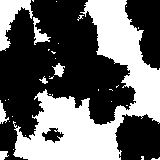

0.38765625


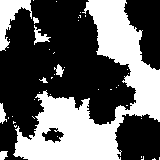

0.37171875


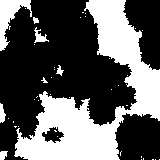

0.3565234375


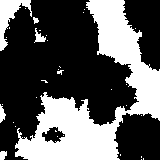

0.3409375


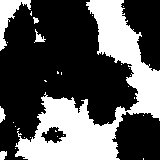

0.3278515625


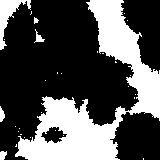

0.313125


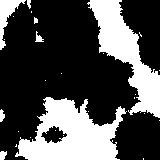

0.30109375


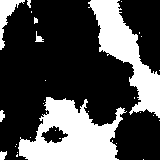

0.2886328125


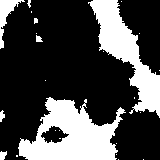

0.27703125


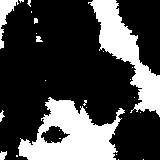

0.264296875


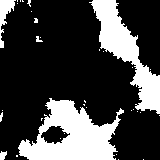

0.2525390625


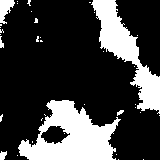

0.239765625


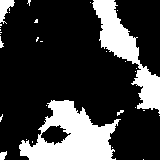

0.226953125


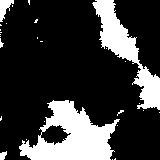

0.2157421875


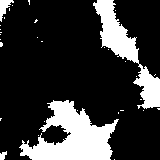

0.204921875


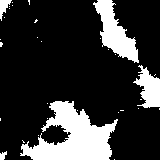

0.193984375


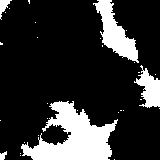

0.1825


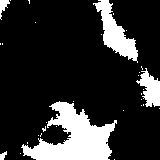

0.1721484375


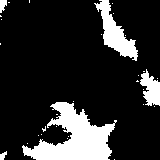

0.1624609375


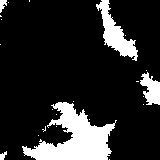

0.1534375


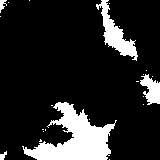

0.144765625


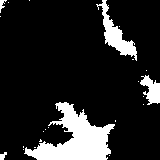

0.1351953125


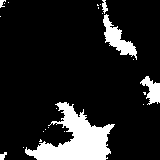

0.126015625


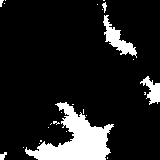

0.118046875


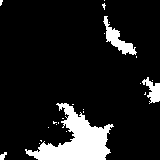

0.1105859375


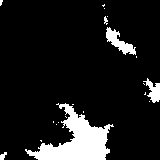

0.1026953125


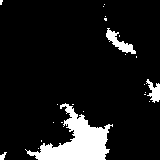

0.0965625


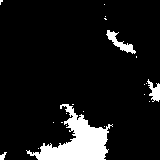

0.0908203125


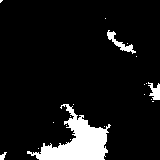

0.0852734375


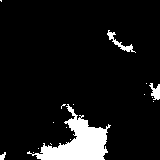

0.0801171875


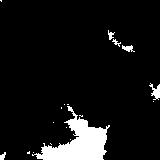

0.0747265625


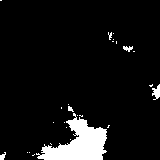

0.0701953125


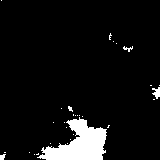

0.0662109375


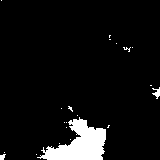

0.063203125


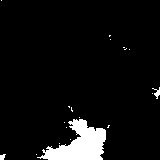

0.0605859375


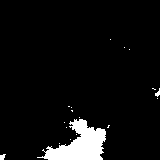

0.05828125


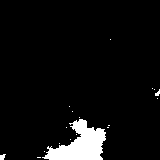

0.056171875


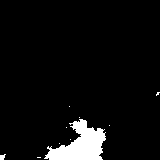

0.0545703125


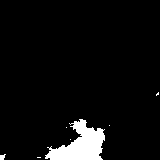

0.053125


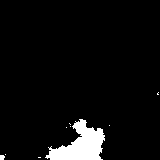

0.0517578125


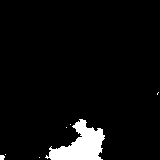

0.050859375


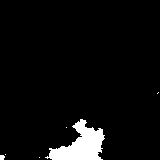

In [4]:
from random import randint
def customGrowth(probSum, numCores, superfluousPar):
    grid=torch.ones((160, 160))
    cores=[]
    coreDir=[]
    #(randint(1, 100)/100)*
    for i in range(numCores):
        x, y=randint(0, 159), randint(0, 159)
        cores.append(deque([[x, y]]))
        growthDirs=[randint(1, 20), randint(1, 20), randint(1, 20), randint(1, 20)]
        coreDir.append([probSum*(randint(1, 100)/100)*x/sum(growthDirs) for x in growthDirs])
        grid[x, y]=0

    print(cores)
    print(coreDir)

    egVol=0
    print(grid.shape)
    totVol=grid.shape[0]*grid.shape[1]
    dirs=[[0,1],[0,-1],[1,0],[-1,0]]
    iters=0
    while (totVol-egVol)/totVol>superfluousPar:
        for i in range(numCores):
            sz=len(cores[i])
            for j in range(sz):
                [coreX, coreY]=cores[i].popleft()
                flag=False
                for dir in range(4):
                    x, y=coreX+dirs[dir][0], coreY+dirs[dir][1]
                    if x<0 or x>=grid.shape[0] or y<0 or y>=grid.shape[1]:
                        continue
                    if random.random()<coreDir[i][dir] and grid[x,y]==1:
                        egVol+=1
                        cores[i].append([x, y])
                        grid[x,y]=0
                    if grid[x,y]==1:
                        flag=True
                if flag:
                    cores[i].append([coreX, coreY])
        iters+=1
        if iters%5==0:
            print((totVol-egVol)/totVol)
            display(tensorToImageTransform(grid))
    
customGrowth(0.5, 30, .05)